# Compare model with UDB and SERPENT data

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

In [2]:
model_dict = pickle.load(open('lin_dep.pkl', 'rb'))

In [50]:
data_dict = pickle.load(open('all_data.pkl', 'rb'))

In [51]:
udb_df = data_dict['UDB']
serpent_df = data_dict['SERPENT']

In [52]:
iso_list = list(udb_df)[5:]

In [53]:
data_info = {'Type': ['SERPENT', 'UDB'],
             'number of isotopes': [len(list(serpent_df)[:-2]),
                                    len(list(udb_df)[5:])],
             'number of calculations': [serpent_df.shape[0], udb_df.shape[0]]}

info_df = pd.DataFrame.from_dict(data_info)
info_df = info_df.set_index('Type')
info_df

,number of isotopes,number of calculations
Type,,
SERPENT,1114,210
UDB,60,104551


## bu and enrichment distribution

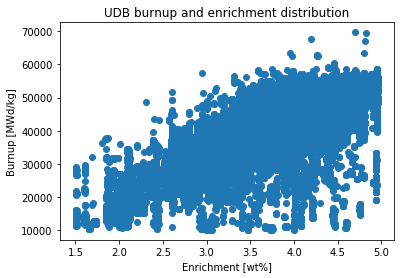

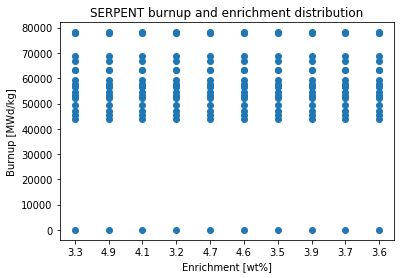

In [54]:
for key, val in data_dict.items():    
    plt.scatter(val['init_enr'], val['bu'])
    plt.xlabel('Enrichment [wt%]')
    plt.ylabel('Burnup [MWd/kg]')
    plt.title('%s burnup and enrichment distribution' %key)
    plt.show()
    plt.close()

In [55]:
z = data_dict['SERPENT'].iloc[0]
for key, val in z.items():
    if val != 0:
        print(key, val)

u-234 4.91783627682e-05
u-235 0.0325968094172
u-238 0.96735401222
init_enr 3.3
